In [1]:
!nvidia-smi

Mon Jun  1 07:09:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Projects/Anomaly_Detection_Time_Series

/content/drive/My Drive/Projects/Anomaly_Detection_Time_Series


In [0]:
import os
import json
import pickle
import matplotlib
import numpy as np
import pandas as po
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
import tensorflow as tf
from nbeats_model import NBeatsNet
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [0]:
os.makedirs('Anomaly_Detection', exist_ok=True)
os.makedirs('Anomaly_Detection/anomaly_grading', exist_ok=True)

In [0]:
class weekday_args:
  def __init__(self):
    self.val_start = 12*24*150
    self.test_start = 12*24*200
    self.train_seq_len = 12*24*10
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 512
    self.num_epochs = 100
    self.hidden_dim = 100
    self.theta_1 = 288*7
    self.theta_2 = 288*7
    self.nb_blocks_per_stack = 5
    
    self.upper_quantile = 0.96
    self.lower_quantile = 0.01

    self.save_folder = 'grading_weekday_anomalies_upper_{}_lower_{}'.format(int(100*self.upper_quantile), int(100*self.lower_quantile))

In [0]:
args = weekday_args()

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [11]:
weekday_power_series = []
weekend_power_series = []
for i in tqdm(range(0, len(df)-7, 7*288)):
  weekday_power_series += df['W'][i:i+5*288].tolist()
  weekend_power_series += df['W'][i+5*288:i+7*288].tolist()
weekday_power_series = np.array(weekday_power_series)
weekend_power_series = np.array(weekend_power_series)

100%|██████████| 50/50 [00:00<00:00, 2898.62it/s]


In [0]:
os.makedirs('Anomaly_Detection/' + args.save_folder, exist_ok=True)

In [0]:
train_arr = weekday_power_series[: args.val_start]
val_arr = weekday_power_series[args.val_start: args.test_start]
test_arr = weekday_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [15]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)
X_test, y_test = make_windows(test_arr)

100%|██████████| 11233/11233 [00:01<00:00, 7544.87it/s]


In [0]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [0]:
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis = -1)

In [0]:
loss_u = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.upper_quantile)
loss_l = lambda y_true, y_pred : pinball_loss(y_true, y_pred, args.lower_quantile)

In [20]:
model_u = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_u.compile_model(loss=loss_u, learning_rate = 1e-3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          288100      lambda_1[0][0]                   
                                                                 subtract_1[0][0]                 
                                                                 subtract_2[0][0]                 
                                                                 subtract_3[0][0]           

In [21]:
history_u = model_u.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 8s 210us/step - loss: 0.0213 - val_loss: 0.0087
Epoch 2/100
40033/40033 [==============================] - 6s 151us/step - loss: 0.0073 - val_loss: 0.0085
Epoch 3/100
40033/40033 [==============================] - 6s 152us/step - loss: 0.0066 - val_loss: 0.0084
Epoch 4/100
40033/40033 [==============================] - 6s 152us/step - loss: 0.0058 - val_loss: 0.0083
Epoch 5/100
40033/40033 [==============================] - 6s 153us/step - loss: 0.0056 - val_loss: 0.0089
Epoch 6/100
40033/40033 [==============================] - 6s 154us/step - loss: 0.0052 - val_loss: 0.0077
Epoch 7/100
40033/40033 [==============================] - 6s 156us/step - loss: 0.0050 - val_loss: 0.0095
Epoch 8/100
40033/40033 [==============================] - 6s 156us/step - loss: 0.0049 - val_loss: 0.0086
Epoch 9/100
40033/40033 [==============================] - 6s 158us/step - loss: 0.0047 - val_

In [22]:
best_epoch = np.argmin(np.array(history_u.history['val_loss']))+1
model_u.save_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
model_u.load_weights('Anomaly_Detection/' + args.save_folder + '/model_upper_{:02d}.h5'.format(best_epoch))
best_epoch

6

In [0]:
y_pred_u = model_u.predict(X_test)

In [24]:
model_l = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_l.compile_model(loss=loss_l, learning_rate = 1e-3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          288100      lambda_2[0][0]                   
                                                                 subtract_11[0][0]                
                                                                 subtract_12[0][0]                
                                                                 subtract_13[0][0]          

In [25]:
history_l = model_l.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 7s 178us/step - loss: 0.0074 - val_loss: 0.0018
Epoch 2/100
40033/40033 [==============================] - 6s 160us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/100
40033/40033 [==============================] - 6s 160us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/100
40033/40033 [==============================] - 6s 161us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/100
40033/40033 [==============================] - 6s 162us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/100
40033/40033 [==============================] - 6s 162us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/100
40033/40033 [==============================] - 6s 162us/step - loss: 0.0017 - val_loss: 0.0019


In [26]:
best_epoch = np.argmin(np.array(history_l.history['val_loss']))+1
model_l.save_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
model_l.load_weights('Anomaly_Detection/' + args.save_folder + '/model_lower_{:02d}.h5'.format(best_epoch))
best_epoch

3

In [0]:
y_pred_l = model_l.predict(X_test)

In [29]:
forecasts_l = []
forecasts_u = []
actuals = []
for i in tqdm(range(y_pred_u.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts_u += y_pred_u[12*24*i].reshape(-1).tolist()
  forecasts_l += y_pred_l[12*24*i].reshape(-1).tolist()
  actuals += y_test[12*24*i].reshape(-1).tolist()

100%|██████████| 39/39 [00:00<00:00, 10267.90it/s]


In [0]:
u = np.array([f_u - a for f_u, a in zip(forecasts_u, actuals)])
u_t = np.where(u < 0, actuals, None) #f_u < a -> anomaly
u_dev = np.where(u < 0, u, 0).astype(np.float)

In [0]:
l = np.array([a - f_l for a, f_l in zip(actuals, forecasts_l)])
l_t = np.where(l < 0, actuals, None)
l_dev = np.where(l < 0, l, 0).astype(np.float)

In [0]:
norm = np.array([f_u - f_l for f_u, f_l in zip(forecasts_u, forecasts_l)])

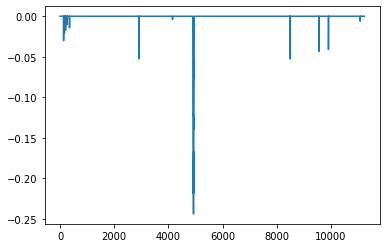

In [108]:
plt.plot(u_dev)
plt.savefig('Anomaly_Detection/anomaly_grading/upper_anomalies.png')

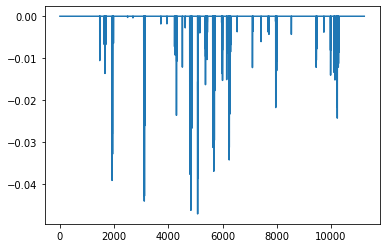

In [109]:
plt.plot(l_dev)
plt.savefig('Anomaly_Detection/anomaly_grading/lower_anomalies.png')

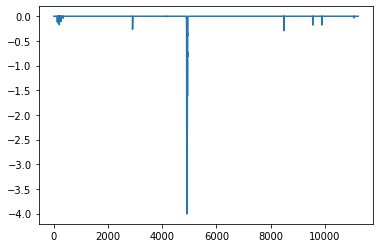

In [107]:
plt.plot(np.divide(u_dev, norm))
plt.savefig('Anomaly_Detection/anomaly_grading/upper_anomalies_normalized.png')

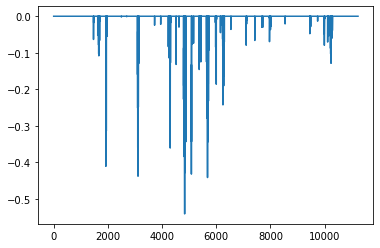

In [110]:
plt.plot(np.divide(l_dev, norm))
plt.savefig('Anomaly_Detection/anomaly_grading/lower_anomalies_normalized.png')

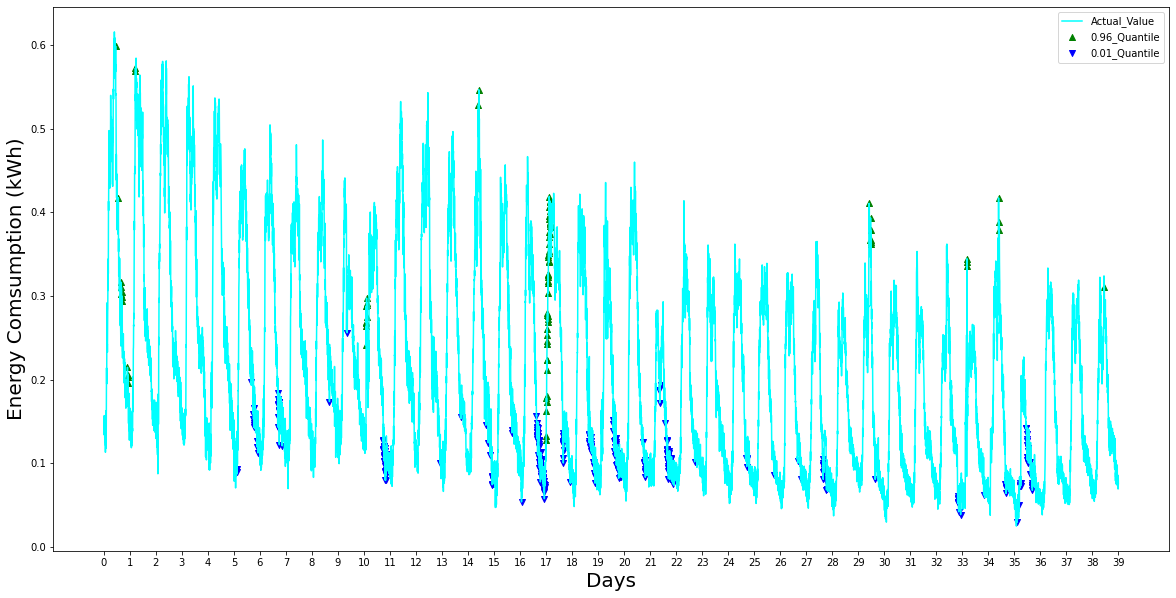

In [32]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts_u) + 1, 288)), labels = list(range(0, int(len(forecasts_u)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'cyan')
plt.scatter(range(len(u_t)), u_t, color = 'green', marker = "^")
plt.scatter(range(len(l_t)), l_t, color = 'blue', marker = "v")
plt.legend(['Actual_Value', '{}_Quantile'.format(args.upper_quantile), '{}_Quantile'.format(args.lower_quantile)])
plt.savefig('Anomaly_Detection/' + args.save_folder + '/anomalies_actuals_weekday_{}_{}.png'.format(args.upper_quantile, args.lower_quantile))